In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop2.7.tgz
!tar xf spark-3.0.0-preview2-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [5]:
col_names = ["word_freq_make","word_freq_address","word_freq_all","word_freq_3d","word_freq_our",'word_freq_over','word_freq_remove',
            "word_freq_internet",'word_freq_order','word_freq_mail','word_freq_receive','word_freq_will','word_freq_people',
            'word_freq_report','word_freq_addresses','word_freq_free','word_freq_business','word_freq_email','word_freq_you',
            "word_freq_credit",'word_freq_your','word_freq_font','word_freq_000','word_freq_money','word_freq_hp','word_freq_hpl',
            'word_freq_george','word_freq_650','word_freq_lab','word_freq_labs',"word_freq_telnet",'word_freq_857','word_freq_data',
            'word_freq_415','word_freq_85','word_freq_technology',"word_freq_1999","word_freq_parts","word_freq_pm","word_freq_direct",
            "word_freq_cs","word_freq_meeting","word_freq_original","word_freq_project","word_freq_re","word_freq_edu","word_freq_table",
            "word_freq_conference","char_freq_;","char_freq_(","char_freq_[","char_freq_!","char_freq_$","char_freq_#","capital_run_length_average",
            "capital_run_length_longest","capital_run_length_total","target_spam"]
dataset1 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data", names = col_names)

dataset1.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,target_spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [6]:
target = dataset1.pop("target_spam")
dataset1.insert(0,"target",target)
dataset1

,target,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,1,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61,278
1,1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101,1028
2,1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.00,0.06,0.06,0.0,0.0,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485,2259
3,1,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40,191
4,1,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40,191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,0.00,1.88,0.00,0.00,0.00,0.00,0.00,0.00,0.62,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.31,0.31,0.31,0.0,0.0,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3,88
4597,0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.00,0.00,2.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,2.00,0.0,0.0,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4,14
4598,0,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.80,0.30,0.00,0.00,0.00,0.00,0.90,1.50,0.00,0.30,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,1.20,0.0,0.0,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6,118
4599,0,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.32,0.00,0.00,0.00,0.00,0.00,0.00,1.93,0.00,0.32,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.32,0.00,0.32,0.0,0.0,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5,78


In [0]:
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
from pyspark import SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

In [0]:
sc = SparkContext()


In [0]:
spark = SparkSession(sc)

In [0]:
data = spark.createDataFrame(dataset1)
data = data.rdd

In [0]:
new_data = data.map(lambda line: LabeledPoint(line[0],[line[1:]]))


In [12]:
print(new_data.take(3))

[LabeledPoint(1.0, [0.0,0.64,0.64,0.0,0.32,0.0,0.0,0.0,0.0,0.0,0.0,0.64,0.0,0.0,0.0,0.32,0.0,1.29,1.93,0.0,0.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.778,0.0,0.0,3.7560000000000002,61.0,278.0]), LabeledPoint(1.0, [0.21,0.28,0.5,0.0,0.14,0.28,0.21,0.07,0.0,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.0,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.132,0.0,0.37200000000000005,0.18,0.048,5.114,101.0,1028.0]), LabeledPoint(1.0, [0.06,0.0,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.0,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.14300000000000002,0.0,0.276,0.184,0.01,9.821,485.0,2259.0])]


In [0]:
target = dataset1.pop("target")


In [14]:
target = target.values.reshape(4601,1).astype(np.int64)
target

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [0]:
def Accuracy(test,pred):
    count = 0
    for x,j in zip(test,pred):
        if x == j:
            count += 1
    accuracy = (count/float(len(test)))*100
    return accuracy

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset1, target, test_size = 0.2, random_state = 0)
y_train

array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]])

In [0]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf',random_state = 0)

In [92]:
from sklearn.model_selection import GridSearchCV
c=[np.arange(800, 900, 1)]
parameters = [
    {'C':c[0]}
]
grid_search = GridSearchCV(estimator = svm ,param_grid =parameters, scoring ='accuracy',cv= 5, n_jobs =-1  )
grid_search = grid_search.fit(X_train,y_train)
best_result = grid_search.best_score_
print('best_result {}'.format(best_result))
best_parameters = grid_search.best_params_
print('best_parameters {}'.format(best_parameters))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


best_result 0.8980978260869564
best_parameters {'C': 898}


In [97]:
param_learnt = grid_search.cv_results_["params"]
accuracy = grid_search.cv_results_['mean_test_score']
cc = []
for i in param_learnt:
  cc.append(i["C"])
score_table = pd.DataFrame({'C':cc, "accuracy":accuracy })
score_table

,C,accuracy
0,800,0.892935
1,801,0.892935
2,802,0.893207
3,803,0.893207
4,804,0.893207
...,...,...
95,895,0.897826
96,896,0.897826
97,897,0.897826
98,898,0.898098


Text(0.5, 0, "Value of'C'")

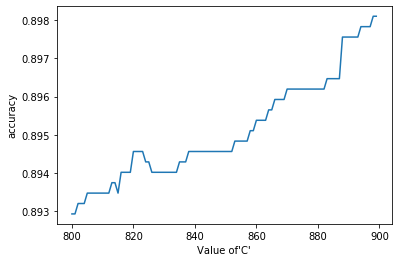

In [99]:
plt.plot(cc,accuracy)
plt.ylabel("accuracy")
plt.xlabel("Value of 'C'")

In [100]:
svm = SVC(C =989 ,kernel = 'rbf', random_state = 0)
svm.fit(X_train,y_train)
# Predicting the Test set results
y_pred = svm.predict(X_test)
svm_model_pred_test_df = pd.DataFrame({'Expected':y_test.reshape(921), 'Predicted':y_pred })
acc = Accuracy(y_test,y_pred)
print("The Accuracy of the model onn test set is :", acc)
print(svm_model_pred_test_df.head(20))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Accuracy of the model onn test set is : 90.33659066232356
    Expected  Predicted
0          1          1
1          0          0
2          0          0
3          1          1
4          0          0
5          0          0
6          0          0
7          0          0
8          1          1
9          0          0
10         1          1
11         0          0
12         1          1
13         1          1
14         0          0
15         0          0
16         1          1
17         1          1
18         1          1
19         1          0


In [0]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)

In [22]:
maxi = np.linspace(1, 50, 50, endpoint=True)
minn = np.linspace(0.1, 1.0, 20, endpoint=True)
parameters = [
    {'max_depth':maxi, "min_samples_split":minn}, 
]
grid_search = GridSearchCV(estimator = clf ,param_grid =parameters, scoring ='accuracy',cv= 5, n_jobs =-1  )
grid_search = grid_search.fit(X_train,y_train)
best_result = grid_search.best_score_
print('best_result {}'.format(best_result))
best_parameters = grid_search.best_params_
print('best_parameters {}'.format(best_parameters))

best_result 0.8899456521739131
best_parameters {'max_depth': 8.0, 'min_samples_split': 0.1}


In [67]:
param_learnt = grid_search.cv_results_["params"]
accuracy = grid_search.cv_results_['mean_test_score']
print(accuracy.shape)
print(len(param_learnt))

(1000,)
1000


In [69]:
maxdepth = []
minsamp = []
for i in param_learnt:
  maxdepth.append(i["max_depth"])
  minsamp.append(i["min_samples_split"])
score_table = pd.DataFrame({'max_depth':maxdepth, 'min_samples_split':minsamp, "accuracy":accuracy })
score_table

,max_depth,min_samples_split,accuracy
0,1.0,0.100000,0.785326
1,1.0,0.147368,0.785326
2,1.0,0.194737,0.785326
3,1.0,0.242105,0.785326
4,1.0,0.289474,0.785326
...,...,...,...
995,50.0,0.810526,0.785326
996,50.0,0.857895,0.785326
997,50.0,0.905263,0.785326
998,50.0,0.952632,0.785326


In [21]:
clf = DecisionTreeClassifier(max_depth =8 ,min_samples_split = 0.1, random_state = 0)
clf.fit(X_train,y_train)
# Predicting the Test set results
y_pred = clf.predict(X_test)
svm_model_pred_test_df = pd.DataFrame({'Expected':y_test.reshape(921), 'Predicted':y_pred })
acc = Accuracy(y_test,y_pred)
print("The Accuracy of the model onn test set is :", acc)
print(svm_model_pred_test_df.head(20))

The Accuracy of the model onn test set is : 88.49077090119435
    Expected  Predicted
0          1          1
1          0          0
2          0          0
3          1          1
4          0          0
5          0          0
6          0          0
7          0          0
8          1          1
9          0          0
10         1          1
11         0          0
12         1          1
13         1          1
14         0          0
15         0          0
16         1          1
17         1          1
18         1          1
19         1          0
